In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os
import random
from kneed import KneeLocator

import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [2]:
def showImages(idxs, image_files=None, images=None):
    plt.figure(figsize=(20, 10))
    if image_files is not None:
        for i, idx in enumerate(idxs):
            img = cv2.imread(image_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    elif images is not None:
        for i in range(len(idxs)):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i], cmap='gray')  # Hiển thị ảnh xám
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    else:
        raise ValueError("Cần cung cấp ít nhất một trong hai tham số: image_files hoặc images")

    plt.show()

1. Tiền xử lý dữ liệu

Số lượng ảnh (thư mục image): 4237
3 ảnh ngẫu nhiên:


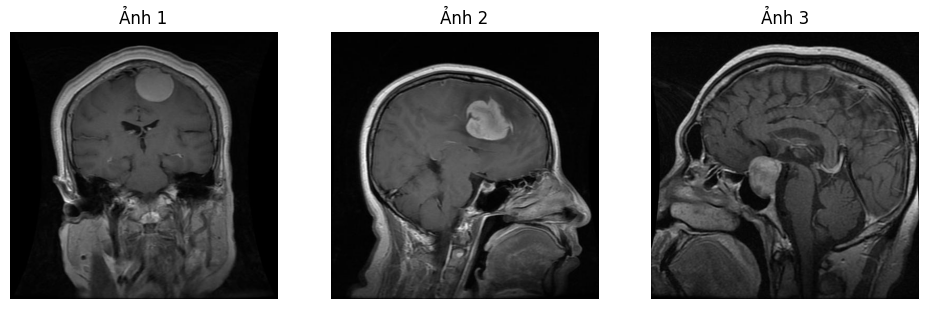

In [13]:
data_dir = r'./Brain Tumor Segmentation Dataset/image'
image_files = []

# Đọc tất cả ảnh gốc vào image_files
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

# Kiểm tra số lượng ảnh
print(f"Số lượng ảnh (thư mục image): {len(image_files)}")

# Hiển thị ngẫu nhiên 3 ảnh mẫu
sample_idxs = random.sample(range(len(image_files)), min(3, len(image_files)))

print("3 ảnh ngẫu nhiên:")
showImages(sample_idxs, image_files=image_files)

3 ảnh xám mẫu:


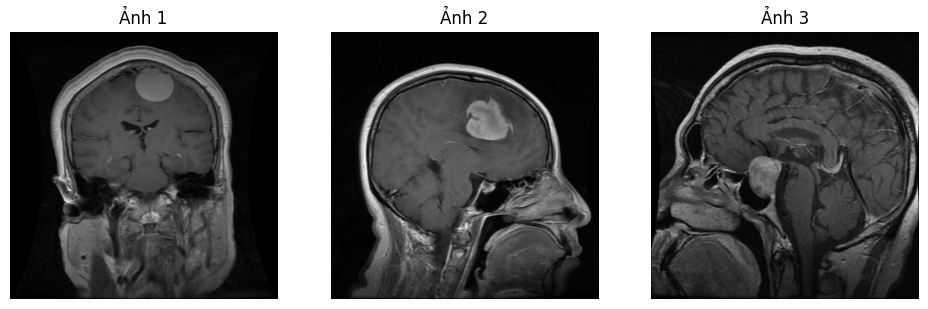

In [14]:
gray_images = []
for idx in sample_idxs:
    gray_img = cv2.imread(image_files[idx], cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray_img)

print("3 ảnh xám mẫu:")
showImages(sample_idxs, images=gray_images)

3 ảnh xám đã resize mẫu:


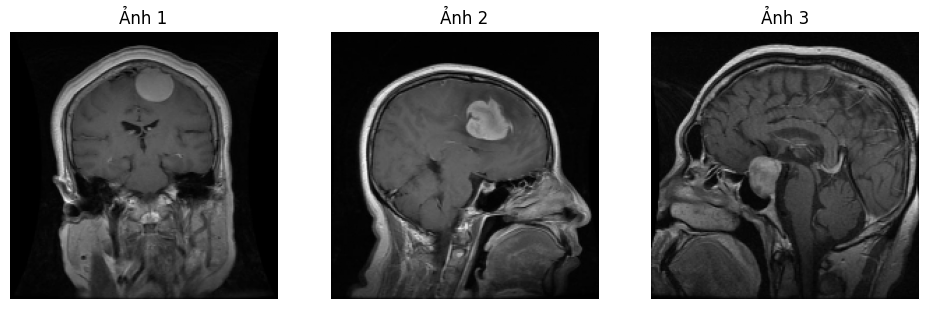

In [15]:
# Resize ảnh về kích thước 192x192
resized_images = []
size = (192, 192)
for img in gray_images:
    resized_img = cv2.resize(img, size, cv2.INTER_AREA)
    resized_images.append(resized_img)

print("3 ảnh xám đã resize mẫu:")
showImages(sample_idxs, images=resized_images)

3 ảnh xám đã cân bằng histogram mẫu:


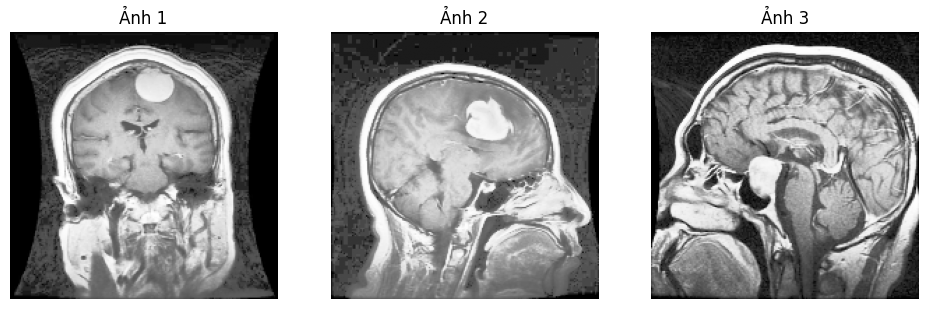

In [16]:
# Cân bằng histogram => Tăng độ tương phản
equalized_images = []
for img in resized_images:
    equalized_img = cv2.equalizeHist(img)  # Cân bằng histogram
    equalized_images.append(equalized_img)

print("3 ảnh xám đã cân bằng histogram mẫu:")
showImages(sample_idxs, images=equalized_images)

3 ảnh xám đã làm mịn mẫu:


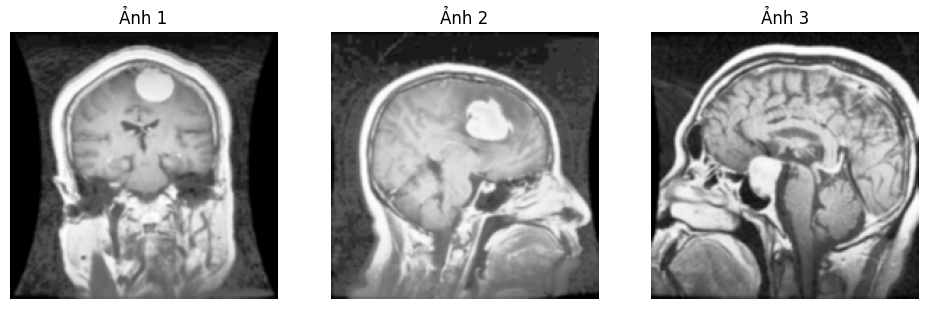

In [17]:
# Làm mịn ảnh
blurred_images = []
for img in equalized_images:
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    blurred_images.append(blurred_img)
print("3 ảnh xám đã làm mịn mẫu:")
showImages(sample_idxs, images=blurred_images)

2. Áp dụng thuật toán DBSCAN

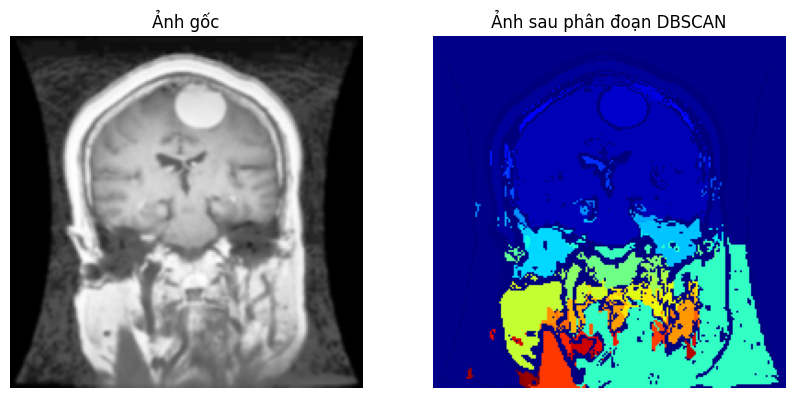

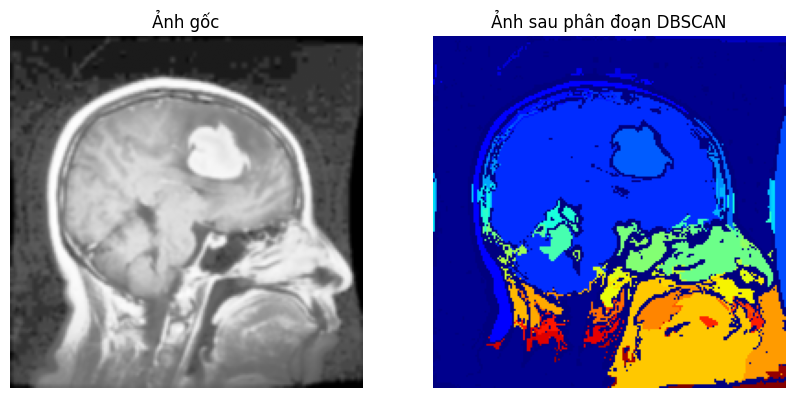

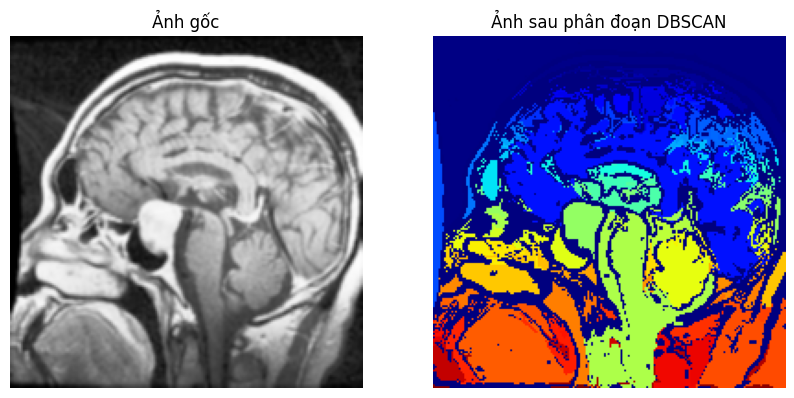

In [18]:
for image in blurred_images:
    h, w = image.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, image.flatten()))
    db = DBSCAN(eps=5, min_samples=10).fit(X)
    labels = db.labels_.reshape(h, w)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    plt.subplot(1, 2, 1)
    plt.title("Ảnh gốc")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Ảnh sau phân đoạn DBSCAN
    plt.subplot(1, 2, 2)
    plt.title("Ảnh sau phân đoạn DBSCAN")
    plt.imshow(labels, cmap='jet')  # Sử dụng cmap='jet' để hiển thị các cụm
    plt.axis('off')

    plt.show()



In [29]:
# Tìm eps tối ưu dựa trên k-distance
from sklearn.neighbors import NearestNeighbors
def getEps(X_scaled):
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_scaled)
    distances, _ = neigh.kneighbors(X_scaled)
    distances = np.sort(distances[:, k-1], axis=0)

    # kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    # knee_eps = kneedle.knee_y

    n_points = len(distances)
    all_coords = np.arange(n_points)
    first_derivative = np.diff(distances)
    second_derivative = np.diff(first_derivative)
    knee_idx = np.argmax(second_derivative) + 1
    knee_eps = distances[knee_idx]
    
    print(knee_eps)

    # plt.figure(figsize=(10, 5))
    # plt.plot(distances, label='k-distance')
    # plt.axhline(y=knee_eps, color='r', linestyle='--', label=f'Estimated eps = {knee_eps:.3f}')
    # plt.title(f"k-distance Graph (k={k})")
    # plt.xlabel("Points (sorted)")
    # plt.ylabel(f"Distance to {k}th Nearest Neighbor")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return knee_eps

In [36]:
# Áp dụng DBSCAN
# db = DBSCAN(eps=4, min_samples=30)
results = []

for _, image in enumerate(blurred_images):
    h, w = image.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, image.flatten())) # tạo mảng (h*w, 3)
    X_scaled = StandardScaler().fit_transform(X)
    eps = getEps(X_scaled)
    clusters = DBSCAN(eps=eps, min_samples=180).fit_predict(X_scaled)
    
    clusterd_image = clusters.reshape(h, w)
    results.append([clusters, clusterd_image])

0.28404224636821146
0.26021177930533695
0.293183589288746


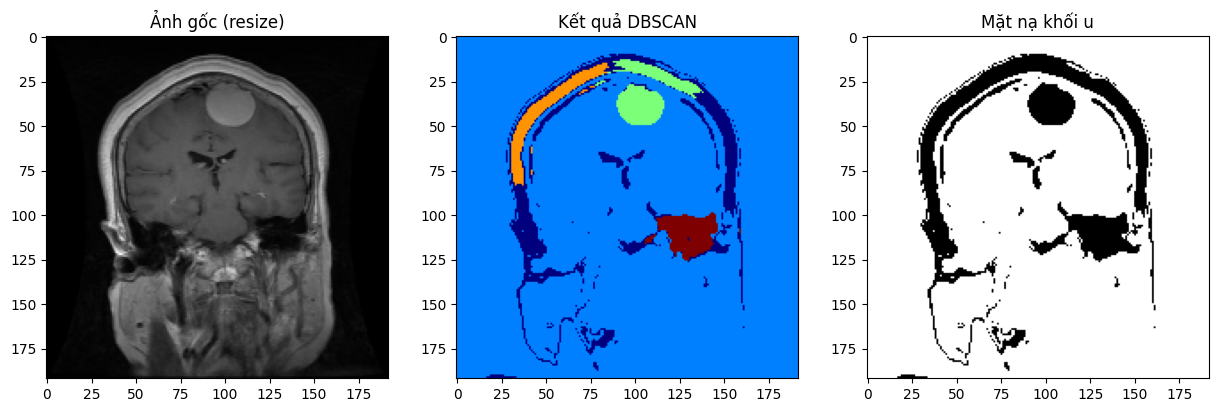

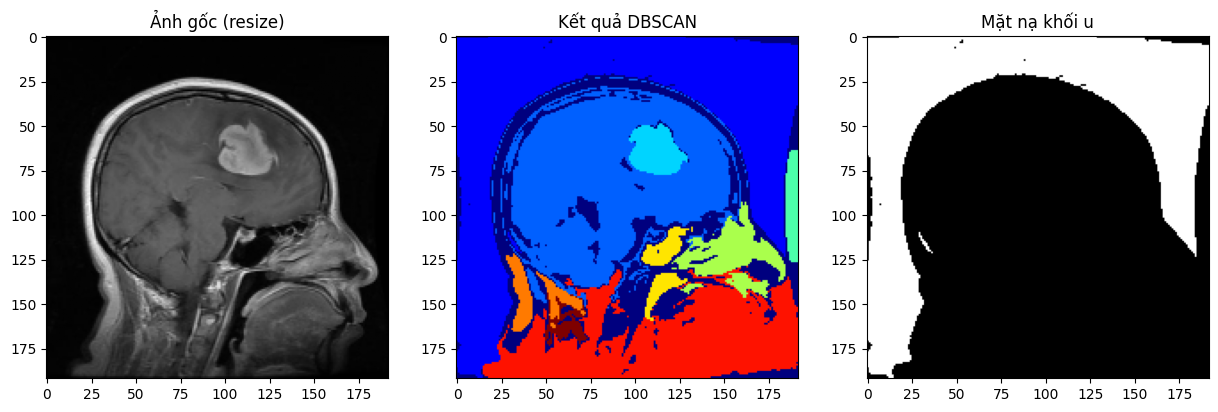

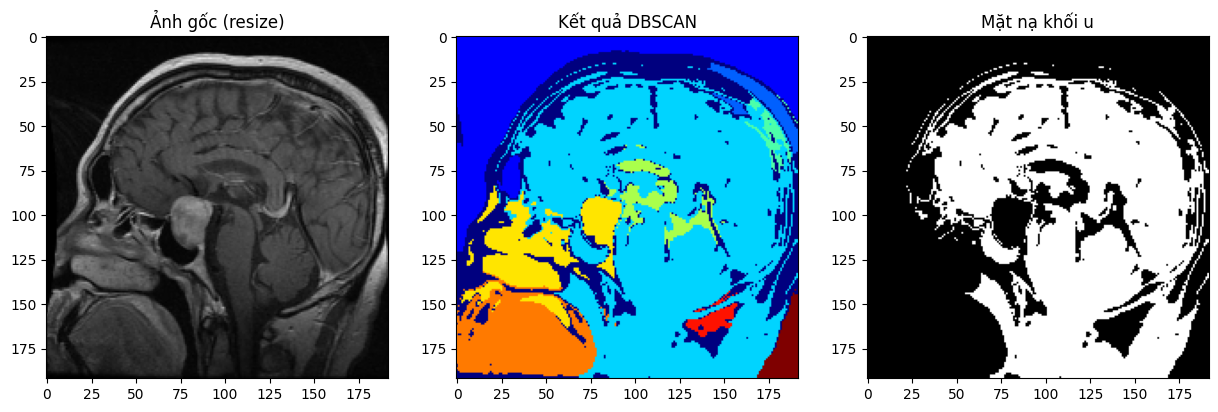

In [40]:
# Hậu xử lý
for i, res in enumerate(results):
    unique_labels, counts = np.unique(res[0][res[0] != -1], return_counts=True)
    if len(unique_labels) > 0:
        tumor_label = unique_labels[np.argmax(counts)]  # Cụm lớn nhất
        tumor_mask = (res[1] == tumor_label).astype(np.uint8) * 255
    else:
        tumor_mask = np.zeros_like(res[1], dtype=np.uint8)

    # Trực quan hóa
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(resized_images[i], cmap='gray')
    plt.title("Ảnh gốc (resize)")
    plt.subplot(1, 3, 2)
    plt.imshow(res[1], cmap='jet')
    plt.title("Kết quả DBSCAN")
    plt.subplot(1, 3, 3)
    plt.imshow(tumor_mask, cmap='gray')
    plt.title("Mặt nạ khối u")
    plt.show()

U-Net

In [2]:
# Đường dẫn truy cập dữ liệu
data_path = "Brain Tumor Segmentation Dataset"
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
images = []
masks = []
labels = []
target_size = (128, 128)

# Bước 1: Tải hình ảnh và mặt nạ
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        for image_name in tqdm(os.listdir(image_folder), desc=f"Đang tải {class_name}"):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)  # Thay đổi kích thước hình ảnh
                image = image / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)  # Thay đổi kích thước mặt nạ
                    mask = mask / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                    
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                else:
                    print(f"Mặt nạ bị thiếu cho hình ảnh: {image_name}")

# Bước 2: Chuyển đổi danh sách thành mảng NumPy và định dạng lại
images = np.array(images).reshape(-1, 128, 128, 1)  # Thêm chiều kênh (channel)
masks = np.array(masks).reshape(-1, 128, 128, 1)    # Thêm chiều kênh (channel)
labels = np.array(labels)

print(f"Số lượng hình ảnh: {len(images)}")
print(f"Số lượng mặt nạ: {len(masks)}")
print(f"Số lượng nhãn: {len(labels)}")

Đang tải no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

Đang tải glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

Đang tải meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

Đang tải pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Số lượng hình ảnh: 4237
Số lượng mặt nạ: 4237
Số lượng nhãn: 4237


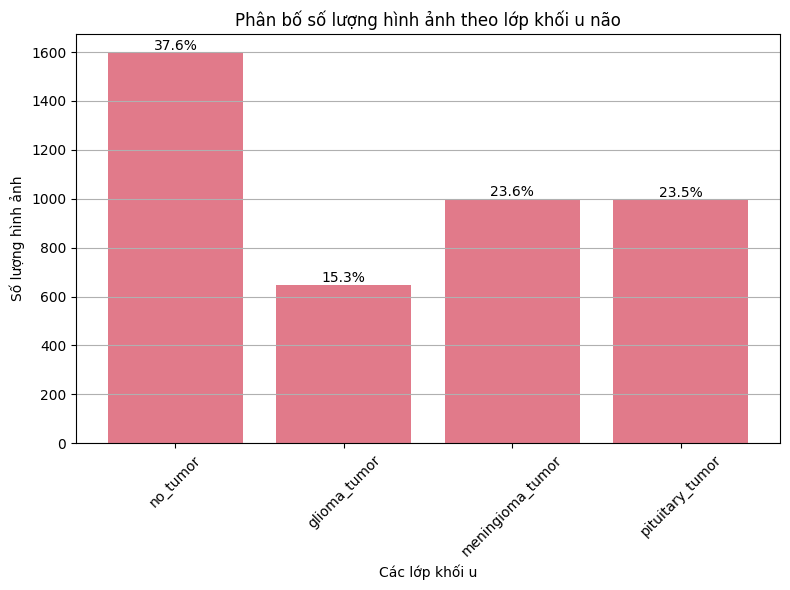

'\nNhận xét: Các lớp thể hiện sự phân bố không cân bằng, với lớp "no tumor" chiếm tỷ lệ đáng kể (37.6%), \ntrong khi các loại khối u khác có tỷ lệ thấp hơn. Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình U-Net.\n'

In [3]:
# Bước 3: Kiểm tra trực quan - Phân bố dữ liệu
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')
plt.xlabel('Các lớp khối u')
plt.ylabel("Số lượng hình ảnh")
plt.title("Phân bố số lượng hình ảnh theo lớp khối u não")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

"""
Nhận xét: Các lớp thể hiện sự phân bố không cân bằng, với lớp "no tumor" chiếm tỷ lệ đáng kể (37.6%), 
trong khi các loại khối u khác có tỷ lệ thấp hơn. Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình U-Net.
"""

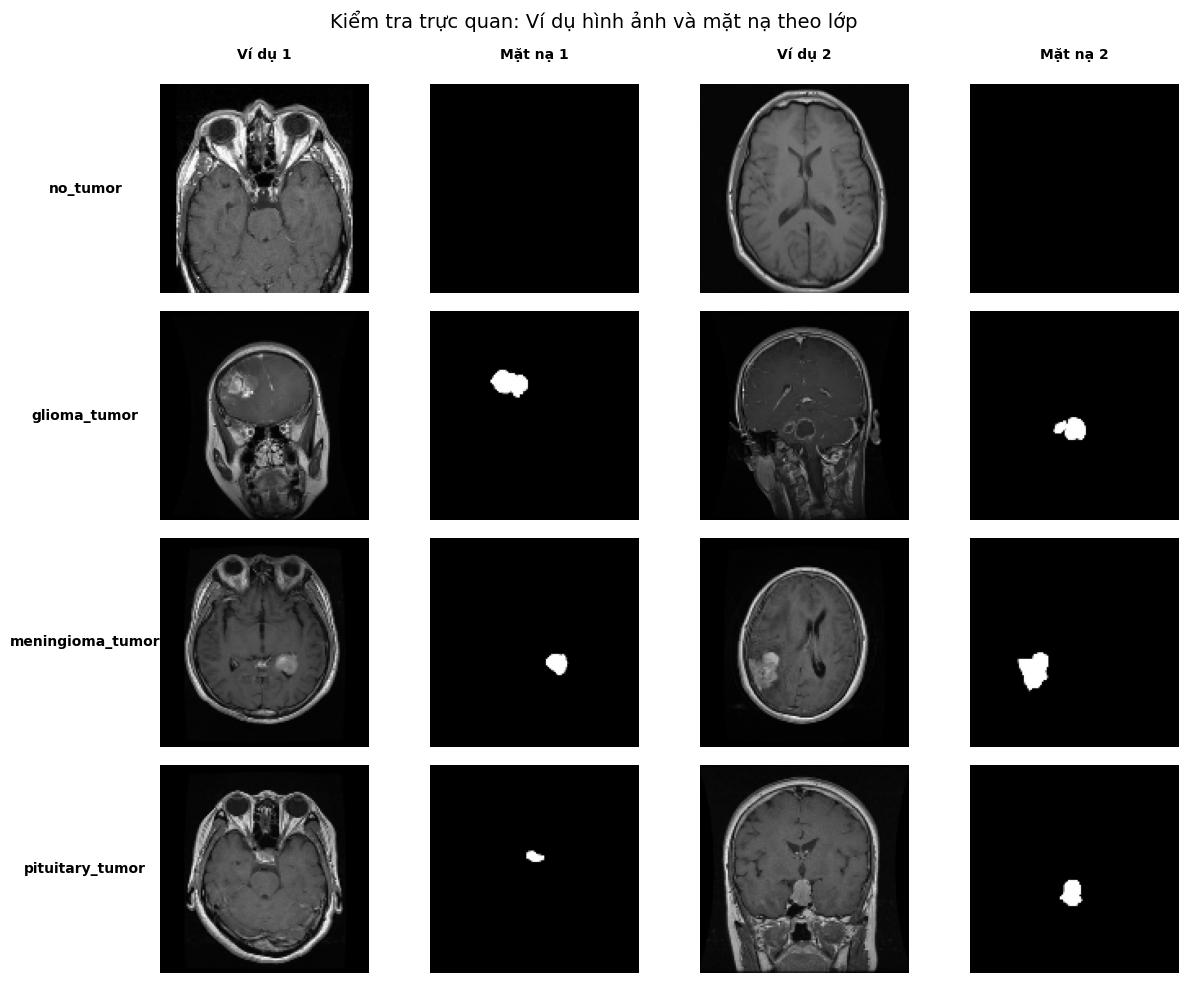

In [4]:
# Bước 4: Kiểm tra trực quan - Hiển thị ví dụ hình ảnh và mặt nạ trước khi chia dữ liệu
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(12, 10), 
                       gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')
axs[0, 1].text(0.5, 0.5, "Ví dụ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')
axs[0, 2].text(0.5, 0.5, "Mặt nạ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')
axs[0, 3].text(0.5, 0.5, "Ví dụ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')
axs[0, 4].text(0.5, 0.5, "Mặt nạ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')

for i, class_name in enumerate(classes):
    class_index = classes.index(class_name)
    example_index1 = np.where(labels == class_index)[0][0]  # Ví dụ đầu tiên
    example_index2 = np.where(labels == class_index)[0][min(2, len(np.where(labels == class_index)[0])-1)]  # Ví dụ thứ ba (nếu có)
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    axs[i + 1, 1].imshow(image1.squeeze(), cmap='gray')
    axs[i + 1, 1].axis('off')
    axs[i + 1, 2].imshow(mask1.squeeze(), cmap='gray')
    axs[i + 1, 2].axis('off')
    axs[i + 1, 3].imshow(image2.squeeze(), cmap='gray')
    axs[i + 1, 3].axis('off')
    axs[i + 1, 4].imshow(mask2.squeeze(), cmap='gray')
    axs[i + 1, 4].axis('off')
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')

plt.suptitle("Kiểm tra trực quan: Ví dụ hình ảnh và mặt nạ theo lớp", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Bước 5: Chia dữ liệu thành tập huấn luyện và tập xác thực
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

print(f"Bộ dữ liệu huấn luyện - Hình ảnh: {images_train.shape}, Mặt nạ: {masks_train.shape}, Nhãn: {labels_train.shape}")
print(f"Bộ dữ liệu xác thực - Hình ảnh: {images_val.shape}, Mặt nạ: {masks_val.shape}, Nhãn: {labels_val.shape}")


Bộ dữ liệu huấn luyện - Hình ảnh: (2965, 128, 128, 1), Mặt nạ: (2965, 128, 128, 1), Nhãn: (2965,)
Bộ dữ liệu xác thực - Hình ảnh: (1272, 128, 128, 1), Mặt nạ: (1272, 128, 128, 1), Nhãn: (1272,)


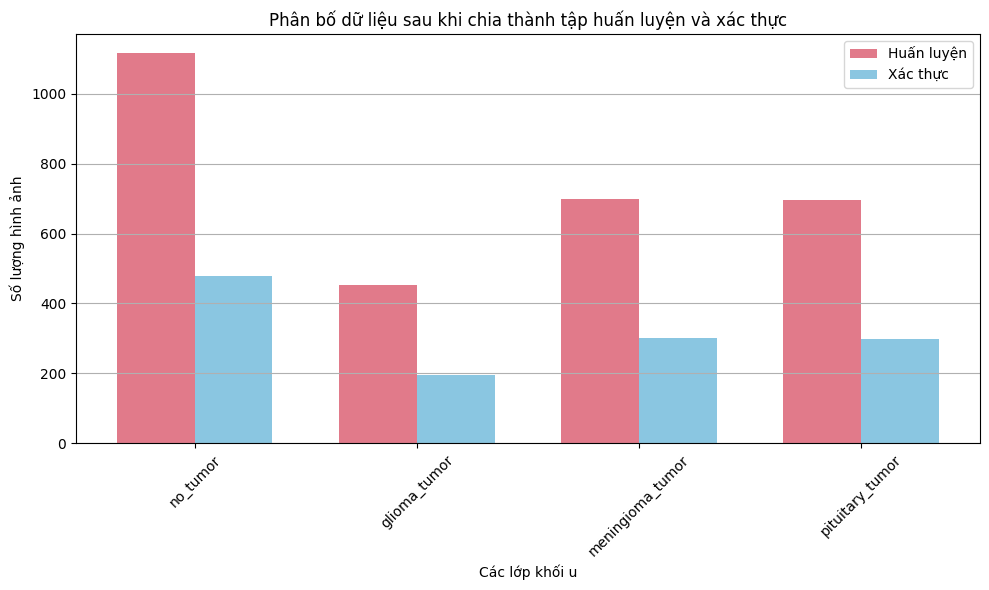

In [6]:
# Bước 6: Kiểm tra trực quan - Phân bố sau khi chia dữ liệu
def plot_split_distribution(labels_train, labels_val, classes):
    train_counts = np.bincount(labels_train)
    val_counts = np.bincount(labels_val)
    class_labels = [classes[i] for i in range(len(classes))]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_counts, width, label='Huấn luyện', color='#E17A8A')
    ax.bar(x + width/2, val_counts, width, label='Xác thực', color='#8AC6E1')
    
    ax.set_xlabel('Các lớp khối u')
    ax.set_ylabel('Số lượng hình ảnh')
    ax.set_title('Phân bố dữ liệu sau khi chia thành tập huấn luyện và xác thực')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.legend()
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

plot_split_distribution(labels_train, labels_val, classes)

In [8]:
# Bước 7: Định nghĩa generator tăng cường dữ liệu
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield img_batch, mask_batch

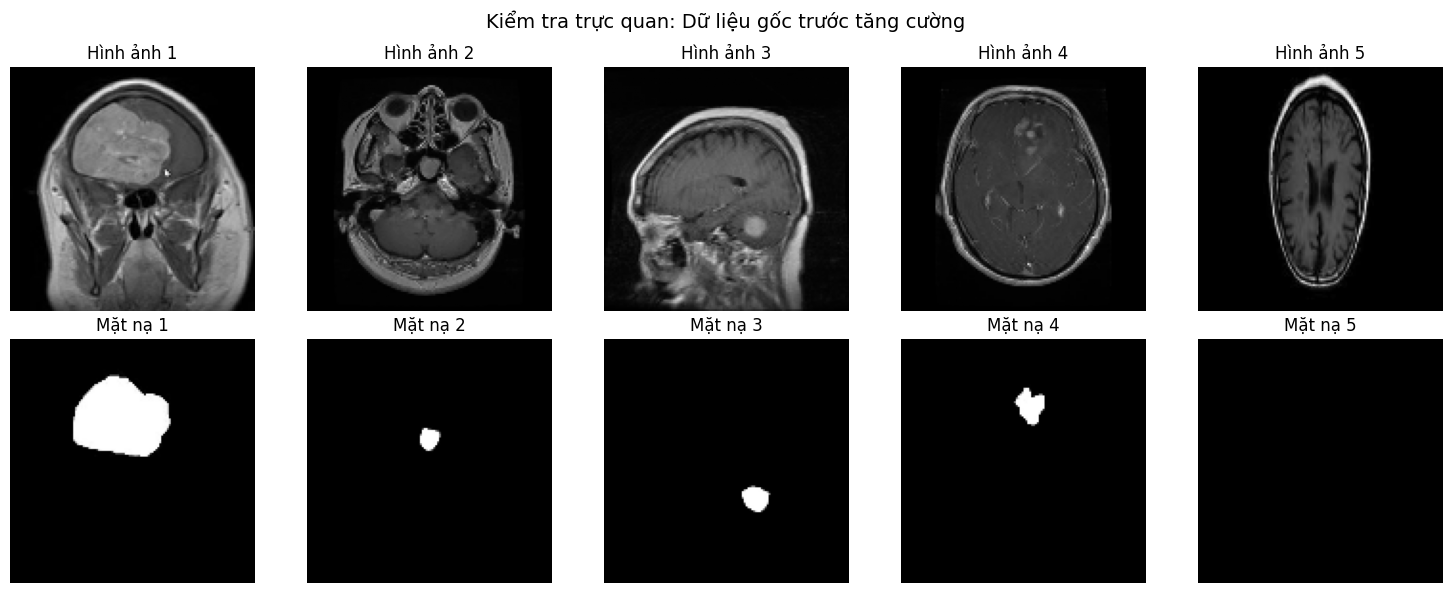

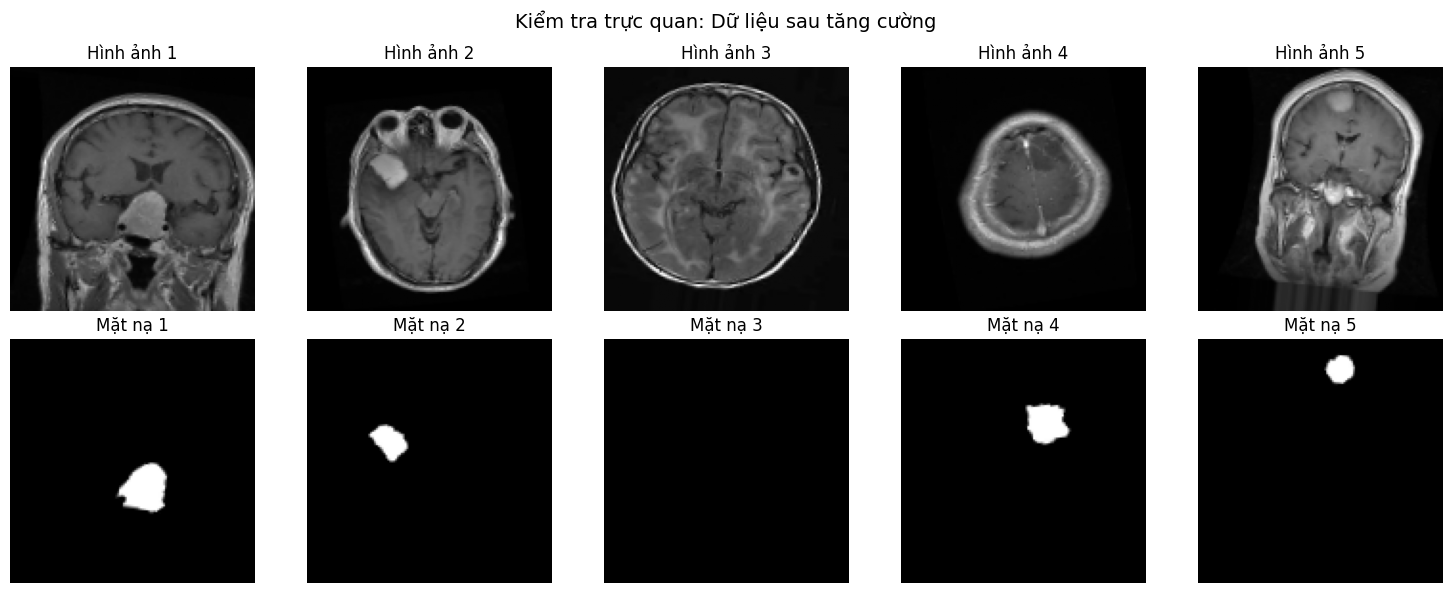

In [9]:
# Bước 8: Kiểm tra trực quan - Hiển thị dữ liệu sau tăng cường
def plot_images(images, masks, num_images=5, title="Hình ảnh và mặt nạ"):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Hình ảnh {i+1}')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Mặt nạ {i+1}')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Kiểm tra dữ liệu gốc trước tăng cường
plot_images(images_train[:5], masks_train[:5], num_images=5, title="Kiểm tra trực quan: Dữ liệu gốc trước tăng cường")

# Kiểm tra dữ liệu sau tăng cường từ generator
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))
plot_images(images_batch, masks_batch, num_images=5, title="Kiểm tra trực quan: Dữ liệu sau tăng cường")


Train model và chạy kết quả

In [ ]:
# Huấn luyện mô hình
"""
Các chỉ số **Dice Coefficient (DICE), Dice Loss và Intersection over Union (IoU)** thường được sử dụng để đánh giá hiệu suất của các mô hình phân đoạn hình ảnh, đặc biệt trong các nhiệm vụ phân đoạn y tế:
"""

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def unet_model(input_shape):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (128, 128, 1)
model = unet_model(input_shape)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

model_checkpoint = ModelCheckpoint('best_unetmodel.keras', monitor='val_dice_coefficient', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_dice_coefficient', patience=10, mode='max', verbose=1)

# Huấn luyện
batch_size = 32
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

# Đánh giá
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Mất mát huấn luyện: {train_loss:.4f}')
print(f'Độ chính xác huấn luyện: {train_accuracy:.4f}')
print(f'Hệ số Dice huấn luyện: {train_dice_coef:.4f}')
print(f'Hệ số IoU huấn luyện: {train_iou_coef:.4f}')

val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Mất mát xác thực: {val_loss:.4f}')
print(f'Độ chính xác xác thực: {val_accuracy:.4f}')
print(f'Hệ số Dice xác thực: {val_dice_coef:.4f}')
print(f'Hệ số IoU xác thực: {val_iou_coef:.4f}')

# Biểu đồ
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(history.history['loss'], label='Mất mát huấn luyện')
axs[0, 0].plot(history.history['val_loss'], label='Mất mát xác thực')
axs[0, 0].set_title('Mất mát qua các Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Mất mát')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()
axs[0, 1].plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
axs[0, 1].plot(history.history['val_accuracy'], label='Độ chính xác xác thực')
axs[0, 1].set_title('Độ chính xác qua các Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Độ chính xác')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].legend()
axs[1, 0].plot(history.history['dice_coefficient'], label='Hệ số Dice huấn luyện')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Hệ số Dice xác thực')
axs[1, 0].set_title('Hệ số Dice qua các Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Hệ số Dice')
axs[1, 0].legend()
axs[1, 1].plot(history.history['iou'], label='IoU huấn luyện')
axs[1, 1].plot(history.history['val_iou'], label='IoU xác thực')
axs[1, 1].set_title('IoU qua các Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()
plt.tight_layout()
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/92 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - accuracy: 0.9597 - dice_coefficient: 0.0178 - iou: 0.0090 - loss: 0.6170

KeyboardInterrupt: 

In [ ]:
# Dự đoán kết quả từ mô hình

# Hàm dự đoán với mô hình đã lưu
def predict_with_saved_model(model_path, test_images):
    loaded_model = models.load_model(model_path, custom_objects={
        'dice_coefficient': dice_coefficient,
        'dice_loss': dice_loss,
        'iou': iou
    })
    predictions = loaded_model.predict(test_images)
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Chuẩn bị dữ liệu thử nghiệm
test_dir = 'Brain Tumor MRI/Testing'
target_size = (128, 128)
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
test_images = []
test_labels = []

for class_name in classes:
    class_folder = os.path.join(test_dir, class_name)
    if os.path.exists(class_folder):
        image_names = os.listdir(class_folder)
        if len(image_names) >= 2:
            for image_name in image_names[:2]:
                image_path = os.path.join(class_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    image = cv2.resize(image, target_size)
                    image = image / 255.0
                    image = np.expand_dims(image, axis=-1)
                    test_images.append(image)
                    test_labels.append(class_name)
                else:
                    print(f"Không thể đọc hình ảnh: {image_path}")
        else:
            print(f"Thư mục {class_folder} có ít hơn 2 hình ảnh")
    else:
        print(f"Thư mục {class_folder} không tồn tại")

test_images = np.array(test_images)
if len(test_images) == 0:
    raise ValueError("Không có hình ảnh thử nghiệm nào được tải")

# Dự đoán với mô hình đã lưu
test_predictions = predict_with_saved_model('best_unetmodel.keras', test_images)

# Hiển thị kết quả
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10), 
                       gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})
titles = ["Lớp", "Hình ảnh 1", "Mặt nạ dự đoán 1", "Hình ảnh 2", "Mặt nạ dự đoán 2"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(test_labels) if label == class_name]
    if len(class_indices) >= 2:
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')
        axs[i + 1, 1].imshow(test_images[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')
        axs[i + 1, 2].imshow(test_predictions[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 2].axis('off')
        axs[i + 1, 3].imshow(test_images[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')
        axs[i + 1, 4].imshow(test_predictions[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 4].axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Brain Tumor MRI/Testing\\no_tumor'